<a href="https://colab.research.google.com/github/dlkt101101/STAT441-Project/blob/main/STAT441_Project_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
Prepared by:\
Darren Alexander Lam Kin Teng\
Ojus Udagani\
Raghuv

In [3]:
!pip install --upgrade tf-keras
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.19.0
    Uninstalling tf_keras-2.19.0:
      Successfully uninstalled tf_keras-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
import keras
import os

In [5]:
from google.colab import drive
from itertools import product
# Keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, RandomFlip, RandomRotation, \
RandomZoom, RandomShear, Normalization, Dropout, Flatten, Lambda
from keras.activations import relu, sigmoid, softmax
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications import VGG16, ResNet50
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import Callback

## Importing the dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive'

In [9]:
training_path = path+'/astro_dataset_maxia/astro_dataset_maxia/training'
test_path = path+'/astro_dataset_maxia/astro_dataset_maxia/test'
validation_path = path+'/astro_dataset_maxia/astro_dataset_maxia/validation'

Creating training, validation and testing batches for images.

In [10]:
BATCH_SIZE =32
IMAGE_SIZE =(224, 224)
SEED = 123

In [11]:
training_batch = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED)
class_names = training_batch.class_names
training_batch = training_batch.prefetch(tf.data.AUTOTUNE)

validation_batch = tf.keras.utils.image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED).prefetch(tf.data.AUTOTUNE)

test_batch = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    follow_links=('.jpg', '.jpeg', '.png'),
    seed=SEED).prefetch(tf.data.AUTOTUNE)

Found 2416 files belonging to 12 classes.
Found 658 files belonging to 12 classes.
Found 345 files belonging to 12 classes.


Visualizing the Images

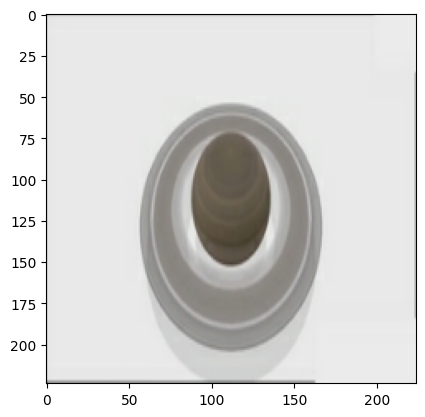

In [12]:
iterator = iter(training_batch)
img = next(iterator)
img = img[0][0].numpy().astype(np.int32)

# let's visualize an image
plt.imshow(img)

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

## Model Implementaion


### Neural Network Implementaion

We will implement multiple pre-trained Convolutional Neural Networks (CNN) and fine-tune them to our astrophysical dataset. Such models include:
* Personal CNN
* VGG16
* ResNet


#### Personal CNN Implementation

##### CNN Predictions

##### CNN Metrics

#### VGG16 Implementation

In [13]:
INPUT_SHAPE = IMAGE_SIZE+(3,)
mVGG16 = VGG16(include_top= False,
              input_shape=INPUT_SHAPE,
              weights='imagenet',
              name = "vgg16")

# we will avoid training on previous layers
for layer in mVGG16.layers:
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
mVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# model = Sequential([
#     RandomRotation(0.5),
#     RandomShear(x_factor=0.9, y_factor=0.9),
#     RandomZoom(0.2),
#     RandomFlip(mode="horizontal_and_vertical"),
#     Lambda(vgg16_preprocess_input),
#     mVGG16,
#     Flatten(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     Dense(len(class_names), activation='softmax')
# ])

# model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=0.001),
#               metrics = ['accuracy'])


In [ ]:
# history_VGG16 = model.fit(x=training_batch, validation_data=validation_batch, epochs=5, verbose=1, batch_size=BATCH_SIZE)

##### VGG16 Parameter Tuning
To improve our model's accuracy, we will perform hyperparameter tuning. However, due to limited computational resources, we will only tune on 3 hyperparameters.
* Number of epochs
* Learning rate
* Weight decay

In [ ]:
# class MetricHistory(Callback):
#   def __init__(self, target_epochs, wd, lr):
#     self.history = []
#     self.wd = wd
#     self.lr = lr
#     self.target_epochs = target_epochs

#   def on_epoch_end(self, epoch, logs=None):
#     current_epoch = epoch +1
#     if current_epoch in self.target_epochs:
#       self.history.append({
#           'epoch': current_epoch,
#           'weight_decay': self.wd,
#           'learning_rate': self.lr,
#           'loss': logs.get('loss'),
#           'accuracy': logs.get('accuracy'),
#           'val_loss': logs.get('val_loss'),
#           'val_accuracy': logs.get('val_accuracy')
#           })


In [16]:
NUM_CLASSES = len(class_names)
epochs = [4,8,12]
MAX_EPOCH = max(epochs)
weight_decays = [0.0, 0.001, 0.0001]
learning_rates = [0.0001, 0.001, 0.01]

# create a dataframe to store the weight decays, learning rate and epochs
parameter_grid = list(product(weight_decays, learning_rates))

In [17]:
def create_compile_model_VGG16(wd, lr, num_classes=NUM_CLASSES):
  model = Sequential([
      RandomRotation(0.5),
      RandomShear(x_factor=0.9, y_factor=0.9),
      RandomZoom(0.2),
      RandomFlip(mode="horizontal_and_vertical"),
      Lambda(vgg16_preprocess_input),
      mVGG16,
      Flatten(),
      Dropout(0.5),
      Dense(256, activation='relu', kernel_regularizer = l2(wd)),
      Dense(len(class_names), activation='softmax', kernel_regularizer = l2(wd))
  ])

  model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=lr),
                metrics = ['accuracy'])

  return model


Iterating over the parameter grid

In [18]:
all_results = []

print(f"Starting {len(parameter_grid)} training runs...")

for i, (wd, lr) in enumerate(parameter_grid):
    print(f"--- Run {i+1}/{len(parameter_grid)}: WD={wd}, LR={lr} ---")
    model = create_compile_model_VGG16(wd, lr)

    # Fit the model to MAX_EPOCH
    historyFit = model.fit(
        x=training_batch,
        validation_data=validation_batch,
        epochs=MAX_EPOCH,
        verbose=0,  # Keep silent for clean output
        batch_size=BATCH_SIZE)

    history_df = pd.DataFrame(historyFit.history)
    history_df['epoch'] = history_df.index + 1
    checkpoint_df = history_df[history_df['epoch'].isin(epochs)].copy()

    checkpoint_df['weight_decay'] = wd
    checkpoint_df['learning_rate'] = lr

    all_results.append(checkpoint_df)

# This merges the 9 DataFrames (3 rows each) into a single 27-row DataFrame.
final_results_df = pd.concat(all_results, ignore_index=True)

Starting 9 training runs...
--- Run 1/9: WD=0.0, LR=0.0001 ---


KeyboardInterrupt: 

In [ ]:
history_df.shape

##### VGG16 Predictions

In [ ]:
predictionsVGG16 = model.predict(x=test_batch, verbose=0)
predictionsVGG16Class = np.argmax(predictionsVGG16, axis=1)

##### VGG16 Metrics

In [ ]:
# get the true labels
true_labels = np.array([])
for images, labels in test_batch:
  true_labels = np.append(true_labels, labels.numpy())

In [ ]:
# calculating class metrics
classReport_VGG16 = classification_report(y_true=true_labels, y_pred=predictionsVGG16Class)
print(classReport_VGG16)

In [ ]:
def plot_preds(model, dataset, class_names, num_images = 9):
  rows = int(np.ceil(np.sqrt(num_images)))
  columns = int(np.ceil(num_images/rows))
  plt.figure(figsize = (columns*3, rows*3))

  for i in range(num_images):
    plt.subplot(rows, columns, i+1)
    image = dataset[
  return None

#### ResNet Implementation

##### ResNet Predictions

##### ResNet Metrics

### Tree Based Models

#### XGBoost